In [3]:
import math
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pyproj import Proj, transform

In [57]:
# Retrieve data
barycentre_dep = pd.read_csv("./data/centre_departement.csv", sep=";")
I = Image.open('./assets/france.png')

# Convigure pyproj to convert GPS WGS84 coordinate to lambert 93 coordinate
# https://geofree.fr/gf/coordinateconv.asp#listSys
# https://fr.wikipedia.org/wiki/Projection_conique_conforme_de_Lambert
xy = Proj(projparams='epsg:2154')
latlon = Proj(projparams='epsg:4326')

In [58]:
# Bottom right corner
origin1_lon = "4°58'12\" O"
origin1_lat = "42°18'14.4\" N" 
origin1_x, origin1_y = 0, 0

# Top left corner
origin2_lon = "8°38'9.6\" E"
origin2_lat = "51°4'30\" N"
origin2_x, origin2_y = I.size

In [59]:
def convert_todeg(deg_str):
    """
        Convert deg°min'sec" to deg,deeeg°
    """
    deg, rest = deg_str.split('°')
    min, rest = rest.split('\'')
    sec, rest = rest.split('\"')
    sign = -1 if 'O' in rest or 'S' in rest else 1
    return sign*(float(deg)+float(min)/60+float(sec)/3600)

origin1_lamb_x, origin1_lamb_y = transform(latlon, xy, convert_todeg(origin1_lat), convert_todeg(origin1_lon))
origin2_lamb_x, origin2_lamb_y = transform(latlon, xy, convert_todeg(origin2_lat), convert_todeg(origin2_lon))
coef2X = (origin2_x - origin1_x)/(origin2_lamb_x - origin1_lamb_x)
coef2Y = (origin2_y - origin1_y)/(origin2_lamb_y - origin1_lamb_y)

# >> Empiric parameters
off_set_x = -46
off_set_y = -6
compenseX = lambda x, y: int(math.tanh(x/200)*40-40) + int(math.tanh((x-1100)/200)*40+40)
compenseY = lambda x, y: int(-math.tanh((y-1000)/200)*40-40) + int(-math.tanh((x+70)/200)*100+100)
# <<
lamb2coordX = lambda x: (x - origin1_lamb_x)*coef2X + origin1_x + off_set_x
lamb2coordY = lambda y: I.size[1] - (y - origin1_lamb_y)*coef2Y + origin1_y + off_set_y

def deg2coord(lat, lon): 
    """
        Convert deg°min'sec" to (x, y) on the plot
    """
    lamb = transform(latlon, xy, convert_todeg(lat), convert_todeg(lon))
    coordX, coordY = int(lamb2coordX(lamb[0])), int(lamb2coordY(lamb[1]))

    # Need compensation to adjust lambert projection on the map
    return coordX + compenseX(coordX, coordY), coordY + compenseY(coordX, coordY)

C:\Users\paull\AppData\Local\Temp/ipykernel_32400/3299320332.py:11: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  origin1_lamb_x, origin1_lamb_y = transform(latlon, xy, convert_todeg(origin1_lat), convert_todeg(origin1_lon))
C:\Users\paull\AppData\Local\Temp/ipykernel_32400/3299320332.py:12: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  origin2_lamb_x, origin2_lamb_y = transform(latlon, xy, convert_todeg(origin2_lat), convert_todeg(origin2_lon))


In [60]:
X, Y = [], []
lat = barycentre_dep["LAT"]
lon = barycentre_dep["LON"]
for i in range(len(barycentre_dep)):
    coord = deg2coord(lat[i], lon[i])
    X.append(coord[0])
    Y.append(coord[1])

barycentre_dep['X'] = X
barycentre_dep['Y'] = Y

barycentre_dep.head()

C:\Users\paull\AppData\Local\Temp/ipykernel_32400/3299320332.py:29: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  lamb = transform(latlon, xy, convert_todeg(lat), convert_todeg(lon))


,DEP,AREA,LON,LAT,X,Y
0,01,5 785,"5°20'56"" E","46°05'58""",802,588
1,02,7 419,"3°33'30"" E","49°33'34""",657,186
2,03,7 380,"3°11'18"" E","46°23'37""",631,557
3,04,6 996,"6°14'38"" E","44°06'22""",885,809
4,05,5 689,"6°15'47"" E","44°39'49""",884,748


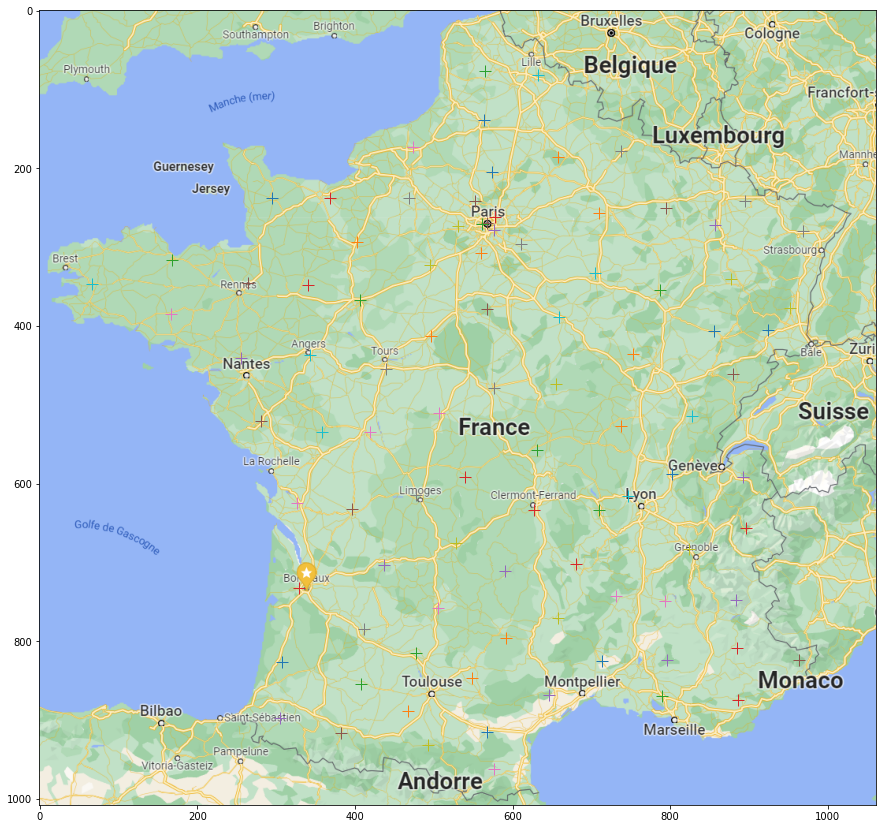

In [61]:
# Plot departement barycenters 
fig, ax = plt.subplots(1, 1, figsize=(15,15))
for dep in barycentre_dep.iloc:
    ax.plot(dep['X'], dep['Y'], marker='+', markersize=12)
    
    # find offset to center 75 Paris marker
    # x, y = deg2coord("48°51'24\"", "2°20'32\" E")
    # ax.plot(x-46, y, marker='+', markersize=12)
    
ax.imshow(I)
plt.show()

In [62]:
population = pd.read_csv("./data/population.csv", sep=";")
pop_iris = population[["DEP","P18_POP"]]
pop_dep = pop_iris.groupby(["DEP"]).sum().reset_index()
dep_list = list(pop_dep["DEP"])
dep_list = [ "0"+str(dep) if str(dep).isdigit() and int(dep) < 10 else str(dep) for dep in dep_list]
pop_dep["DEP"] = dep_list
pop_dep.loc[pop_dep["DEP"] == "33"]["P18_POP"].values[0]

C:\Users\paull\AppData\Roaming\Python\Python38\site-packages\IPython\core\interactiveshell.py:3457: DtypeWarning: Columns (0,2,3,4,7,11) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


1601842

In [63]:
wedding = pd.read_csv("./data/etatcivil2018_mar2018_csv/FD_MAR_2018.csv", sep=";")

value, count = np.unique(wedding["DEPMAR"], return_counts=True)
wedding_per_dep = { value[i]: [count[i], int(barycentre_dep.loc[barycentre_dep['DEP'] == value[i]]["AREA"].values[0].replace(' ','')), pop_dep.loc[pop_dep["DEP"] == value[i]]["P18_POP"].values[0], (barycentre_dep.loc[barycentre_dep['DEP'] == value[i]]['X'].values[0], barycentre_dep.loc[barycentre_dep['DEP'] == value[i]]['Y'].values[0])] for i in range(len(value)) if value[i].isdigit() and int(value[i]) < 100}
wedding_per_dep_small = { value[i]: [count[i], int(barycentre_dep.loc[barycentre_dep['DEP'] == value[i]]["AREA"].values[0].replace(' ','')), pop_dep.loc[pop_dep["DEP"] == value[i]]["P18_POP"].values[0], (barycentre_dep.loc[barycentre_dep['DEP'] == value[i]]['X'].values[0], barycentre_dep.loc[barycentre_dep['DEP'] == value[i]]['Y'].values[0])] for i in range(len(value)) if value[i].isdigit() and int(value[i]) < 10}

# Exemple
wedding_per_dep['01']

C:\Users\paull\AppData\Roaming\Python\Python38\site-packages\IPython\core\interactiveshell.py:3457: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


[2248, 5785, 647632, (802, 588)]

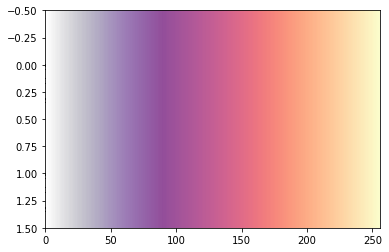

In [64]:
def twoD_Gaussian(c, yo, xo, sigma_x, sigma_y, ampl):
    x, y = c
    a = 1./(2*sigma_x**2) + 1./(2*sigma_y**2)
    c = 1./(2*sigma_x**2) + 1./(2*sigma_y**2)
    g = np.exp( - (a*((x-xo)**2) + c*((y-yo)**2)))
    return g * ampl


def transparent_cmap(cmap, N=255):
    # Copy colormap and set alpha values
    mycmap = cmap
    mycmap._init()
    # mycmap._lut[:,-1] = np.linspace(0, 0.9, N+4)
    alpha = list(np.linspace(0,0.8,90))
    alpha.extend([0.80]*(259-90))
    mycmap._lut[:,-1] = alpha
    # print(len(mycmap), mycmap)
    # alpha = list(np.linspace(0,70,30))
    # alpha.extend([70]*(259-30))
    # mycmap._lut[:,-1] = 70
    return mycmap


#Use base cmap to create transparent
# mycmap = transparent_cmap(plt.cm.Reds)
mycmap = transparent_cmap(plt.cm.magma)

gradient = np.linspace(0,1,256)
gradient = np.vstack((gradient, gradient))
plt.imshow(gradient, aspect='auto', cmap=mycmap)

In [99]:
w, h = I.size
y, x = np.mgrid[0:h, 0:w]
z = np.zeros((x.shape[0], y.shape[1]))
# barycentre = deg2coord("48°51'24\"", "2°20'32\" E")
n = 0
for i in range(len(z)):
    for j in range(len(z[i])):
        if n%1000 == 0:
            print('\r', f"{n*100/(w*h):0.2f}%"," "*20, end="\r")
        for wedding, area, pop, barycentre  in wedding_per_dep.values():
        # barycentre = (200,200)
        # area = 5000
        # wedding = 2500
        # z[i][j] += twoD_Gaussian((i,j), *barycentre, area/100, area/100, wedding)
        # barycentre = (800,800)
        # area = 6000
        # wedding = 3000
            sigma = math.sqrt(area/3.1415)
            dep_y, dep_x = barycentre
            if math.sqrt(((i-dep_x)**2+(j-dep_y)**2)) < 3*sigma: 
                z[i][j] += twoD_Gaussian((i,j), dep_y, dep_x, sigma, sigma, pop)
        n+=1

In [100]:
# np.save("heatmap-pop.npy", z)

In [96]:
# z = np.load("heatmap-normalize-area.npy",z)
# for i in range(len(z)):
#     for j in range(len(z[i])):
#         z[i][j] = min(5e5, z[i][j])
# z = np.load("heatmap-absolute.npy")

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
y, x = np.mgrid[0:h, 0:w]
# z = np.load("heatmap-normalize-pop.npy")
c = ax.pcolormesh(x, y , z, cmap=mycmap)
fig.colorbar(c, ax=ax)
# ax.set_title("Carte de chaleur des régions où on eu lieu des mariages")
ax.imshow(I)
plt.show()

## Plots

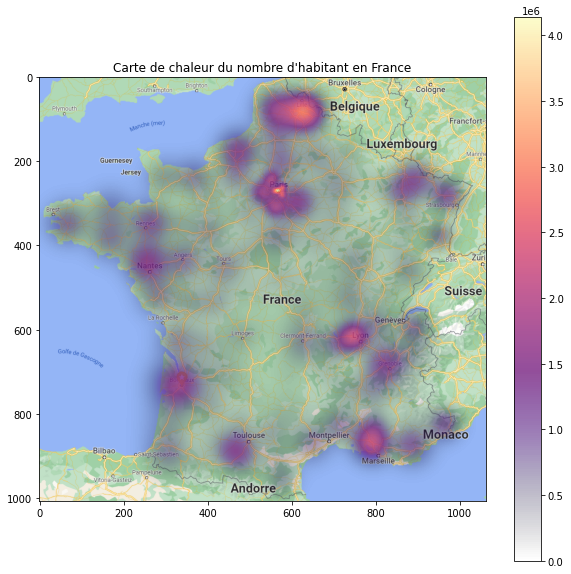

In [101]:

fig, ax = plt.subplots(1, 1, figsize=(10,10))
y, x = np.mgrid[0:h, 0:w]
z = np.load("heatmap-pop.npy")
c = ax.pcolormesh(x, y , z, cmap=mycmap)
fig.colorbar(c, ax=ax)
ax.set_title("Carte de chaleur du nombre d'habitant en France")
ax.imshow(I)
plt.show()

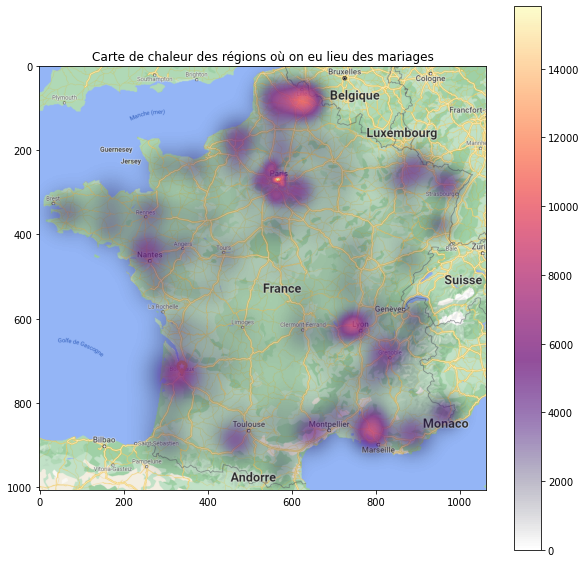

In [86]:

fig, ax = plt.subplots(1, 1, figsize=(10,10))
y, x = np.mgrid[0:h, 0:w]
z = np.load("heatmap-absolute-sigma-radius.npy")
c = ax.pcolormesh(x, y , z, cmap=mycmap)
fig.colorbar(c, ax=ax)
ax.set_title("Carte de chaleur des régions où on eu lieu des mariages")
ax.imshow(I)
plt.show()

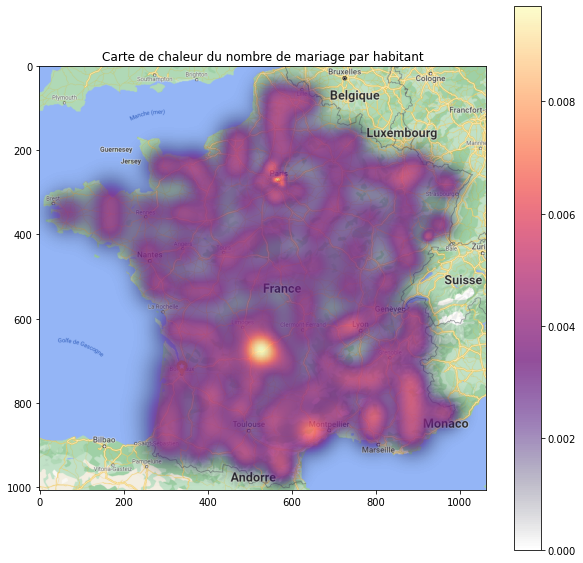

In [87]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
y, x = np.mgrid[0:h, 0:w]
z = np.load("heatmap-absolute-sigma-radius-normalize-pop.npy")
c = ax.pcolormesh(x, y , z, cmap=mycmap)
fig.colorbar(c, ax=ax)
ax.set_title("Carte de chaleur du nombre de mariage par habitant")
ax.imshow(I)
plt.show()